In [ ]:
import tensorflow as tf

# Configure TensorFlow to dynamically allocate GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime
import pytz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Data")
#Connection process ends here

In [ ]:
images_path = '/content/drive/MyDrive/Data/train/image'

In [ ]:
masks_path = '/content/drive/MyDrive/Data/train/mask'

In [ ]:
test_images_path = '/content/drive/MyDrive/Data/test/image'
test_masks_path = '/content/drive/MyDrive/Data/test/mask'

In [ ]:
def load_images(images_path):
    images = []
    image_files = sorted(os.listdir(images_path))

    for img_file in image_files:
        img = cv2.imread(os.path.join(images_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        img = img.astype(np.float32)
        images.append(img)

    return np.array(images)

images = load_images(images_path)

In [ ]:
def load_masks(masks_path):
    masks = []
    mask_files = sorted(os.listdir(masks_path))

    for mask_file in mask_files:
        mask = cv2.imread(os.path.join(masks_path, mask_file), cv2.IMREAD_GRAYSCALE)
        _, binary_mask = cv2.threshold(mask, 1, 1, cv2.THRESH_BINARY)
        binary_mask = binary_mask.astype(np.float32)
        masks.append(binary_mask)

    return np.array(masks)

masks = load_masks(masks_path)

In [ ]:
test_images = load_images(test_images_path)
test_masks = load_masks(test_masks_path)

In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, Rotate, Compose

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
transform = Compose([HorizontalFlip(p=1.0),
                     VerticalFlip(p=1.0),
                     Rotate(limit=45,p=1.0)])

augmented_images = []
augmented_masks = []

for i in range(0,80):
    augmented = transform(image = images[i], mask = masks[i])
    augmented_image = augmented["image"]
    augmented_images.append(augmented_image)
    augmented_mask = augmented["mask"]
    augmented_masks.append(augmented_mask)

In [ ]:
import torch

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
all_masks = np.concatenate((masks, augmented_masks))
all_images = np.concatenate((images, augmented_images))

In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

In [ ]:
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    """Calculate Dice loss."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def combined_bce_dice_loss(y_true, y_pred):
    """Combine Binary Cross-Entropy and Dice Loss."""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + 2*d_loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

def convolution(input, channels):
    """Convolutional block with two convolutional layers and BatchNormalization."""
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(input)
    x = layers.BatchNormalization()(x)  # Batch normalization after the first Conv2D
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)  # Batch normalization after the second Conv2D
    return x

def encoder(input, channels):
    """Encoder block with convolution and max pooling."""
    x = convolution(input, channels)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder(input, skip_features, channels):
    """Decoder block with upsampling and concatenation with skip connections."""
    x = layers.Conv2DTranspose(channels, (2, 2), strides=2, padding='same')(input)
    x = layers.Concatenate()([x, skip_features])
    x = convolution(x, channels)
    return x

def unet_2_layer_bn(input_shape):
    """Constructs the 2-layer U-Net model with BatchNormalization."""
    inputs = layers.Input(input_shape)

    # Encoder
    l1, p1 = encoder(inputs, 64)
    l2, p2 = encoder(p1, 128)

    # Bottleneck
    l = convolution(p2, 256)

    # Decoder
    u1 = decoder(l, l2, 128)
    u2 = decoder(u1, l1, 64)

    # Output layer
    output = layers.Conv2D(1, 1, padding='same', activation="sigmoid")(u2)

    model = models.Model(inputs, output, name="2_LAYER_UNET_BN")
    return model

# Example usage
input_shape = (512, 512, 3)  # Input shape (height, width, channels)
model = unet_2_layer_bn(input_shape)

# Compile the model
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=[dice_score, iou_score])

# Model summary
model.summary()


Model: "2_LAYER_UNET_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 256)  │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 256)  │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 1,867,969 (7.13 MB)

 Trainable params: 1,865,409 (7.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

In [ ]:
# Get current UTC time
utc_now = datetime.now(pytz.utc)

# Convert to your desired time zone (e.g., US Eastern Time)
local_timezone = pytz.timezone('America/New_York')
local_time = utc_now.astimezone(local_timezone)

# Format the time as a string
current_timestamp = local_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the local time
print("Current Time:", local_time.strftime("%Y-%m-%d %H:%M:%S"))

print("U-Net 2 layers with normalization")
history_unet2_wn = model.fit(train_images, train_masks,
            validation_data=(val_images, val_masks),
           epochs = 5,
           batch_size = 1)

pred = model.predict(test_images)
dice_scores = [dice_score(test_masks[i], pred[i]).numpy() for i in range(len(test_masks))]
iou_scores = [iou_score(test_masks[i], pred[i]).numpy() for i in range(len(test_masks))]

mean_dice_score = np.mean(dice_scores)
mean_iou_score = np.mean(iou_scores)


print(current_timestamp)
print(f"Dice Score: {mean_dice_score:.4f}")
print(f"IoU Score: {mean_iou_score:.4f}")

Current Time: 2024-11-07 12:52:43
U-Net 2 layers with normalization
Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - dice_score: 0.4038 - iou_score: 0.2575 - loss: 0.4396 - val_dice_score: 0.0938 - val_iou_score: 0.0492 - val_loss: 0.4046
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - dice_score: 0.6114 - iou_score: 0.4422 - loss: 0.1747 - val_dice_score: 0.0240 - val_iou_score: 0.0122 - val_loss: 0.5896
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - dice_score: 0.6775 - iou_score: 0.5136 - loss: 0.1389 - val_dice_score: 0.2180 - val_iou_score: 0.1251 - val_loss: 0.4526
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - dice_score: 0.7151 - iou_score: 0.5573 - loss: 0.1225 - val_dice_score: 0.4864 - val_iou_score: 0.3276 - val_loss: 0.2840
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - dice_score: 0.7216 - iou_score: 0.5653 - loss: 0.1187 - val_dice_score: 0.5848 - val_iou_score: 0.4166 - val_loss: 0.2105
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
202

In [ ]:
# Save model weights
from google.colab import files
model.save_weights("unet_2_layer_bn.weights.h5")
files.download('unet_2_layer_bn.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

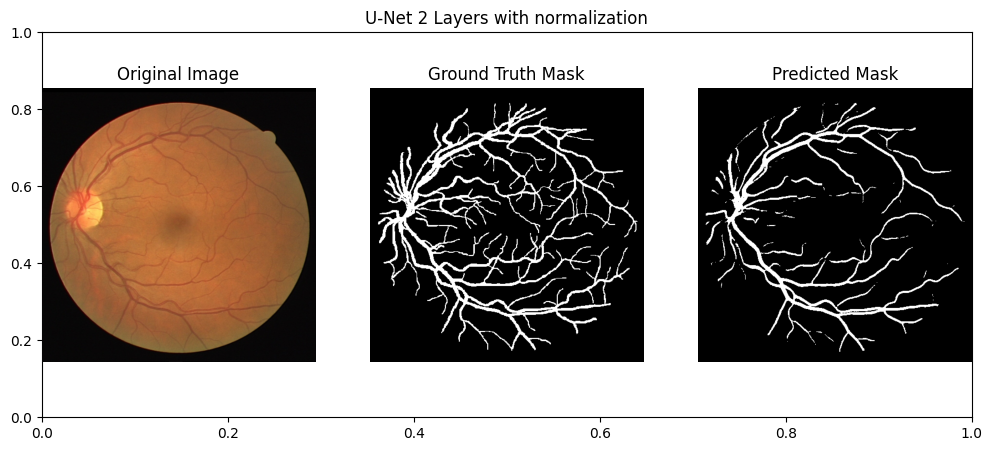

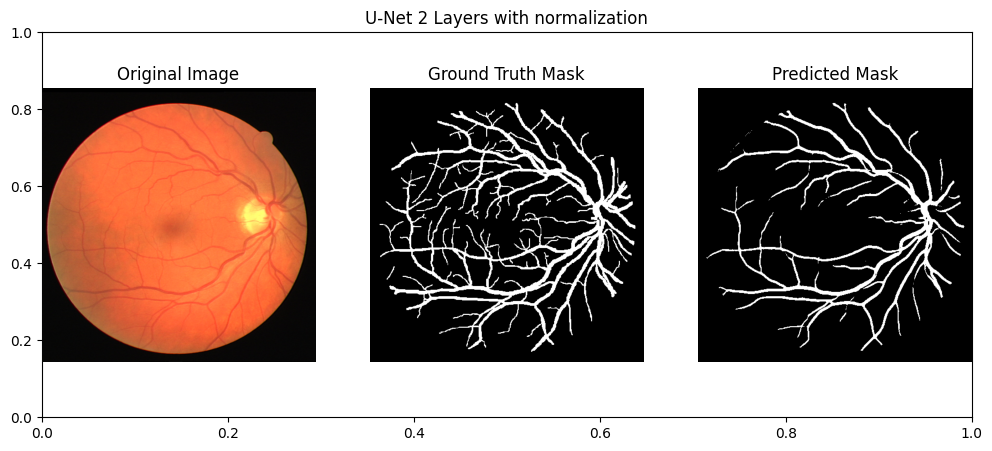

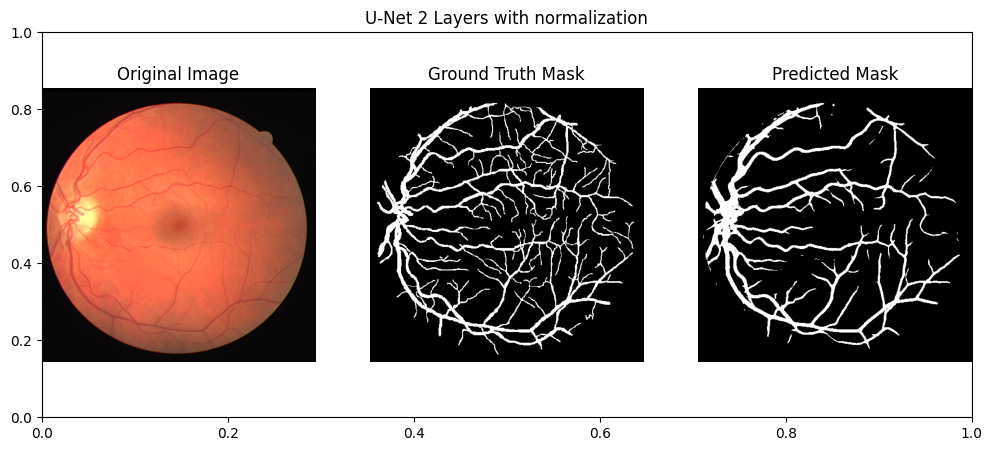

In [ ]:
def display_test_predictions(index):
    # Original image from the test set
    original_image = test_images[index]
    # Ground truth mask from the test set
    ground_truth_mask = test_masks[index]
    # Predicted mask (use `.round()` for binary mask)
    predicted_mask = pred[index].round()

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.title("U-Net 2 Layers with normalization")

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Display predictions for a few samples in the test set
for i in range(3):  # Adjust the range to display more or fewer images
    display_test_predictions(i)

## U-Net 3 layers

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

def convolution(input, channels):
    """Convolutional block with two convolutional layers and BatchNormalization."""
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(input)
    x = layers.BatchNormalization()(x)  # Batch normalization after the first Conv2D
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)  # Batch normalization after the second Conv2D
    return x

def encoder(input, channels):
    """Encoder block with convolution and max pooling."""
    x = convolution(input, channels)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder(input, skip_features, channels):
    """Decoder block with upsampling and concatenation with skip connections."""
    x = layers.Conv2DTranspose(channels, (2, 2), strides=2, padding='same')(input)
    x = layers.Concatenate()([x, skip_features])
    x = convolution(x, channels)
    return x

def unet_3_layer_bn(input_shape):
    """Constructs the 3-layer U-Net model with BatchNormalization."""
    inputs = layers.Input(input_shape)

    # Encoder
    l1, p1 = encoder(inputs, 64)
    l2, p2 = encoder(p1, 128)
    l3, p3 = encoder(p2, 256)

    # Bottleneck
    l = convolution(p3, 512)

    # Decoder
    u1 = decoder(l, l3, 256)
    u2 = decoder(u1, l2, 128)
    u3 = decoder(u2, l1, 64)

    # Output layer
    output = layers.Conv2D(1, 1, padding='same', activation="sigmoid")(u3)

    model = models.Model(inputs, output, name="3_LAYER_UNET_BN")
    return model

# Example usage
input_shape = (512, 512, 3)  # Input shape (height, width, channels)
model = unet_3_layer(input_shape)

# Compile the model
model.compile(optimizer= 'adam', loss= combined_bce_dice_loss, metrics=[dice_score, iou_score])

# Model summary
model.summary()


Model: "3_LAYER_UNET_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 512, 512, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 512, 512, 64)   │            256 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 512, 512, 64)   │         36,928 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 512, 512, 64)   │            256 │ conv2d_61[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 256, 256, 64)   │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 256, 256, 128)  │            512 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 256, 256, 128)  │        147,584 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 256, 256, 128)  │            512 │ conv2d_63[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 128, 128, 128)  │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 128, 128, 256)  │          1,024 │ conv2d_64[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 128, 128, 256)  │        590,080 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 128, 128, 256)  │          1,024 │ conv2d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
# Get current UTC time
utc_now = datetime.now(pytz.utc)

# Convert to your desired time zone (e.g., US Eastern Time)
local_timezone = pytz.timezone('America/New_York')
local_time = utc_now.astimezone(local_timezone)

# Format the time as a string
current_timestamp = local_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the local time
print("Current Time:", local_time.strftime("%Y-%m-%d %H:%M:%S"))

print("U-Net with 3 layers with normalization")
history_unet3_wn = model.fit(train_images, train_masks,
            validation_data=(val_images, val_masks),
           epochs = 5,
           batch_size = 1)

pred = model.predict(test_images)
dice_scores = [dice_score(test_masks[i], pred[i]).numpy() for i in range(len(test_masks))]
iou_scores = [iou_score(test_masks[i], pred[i]).numpy() for i in range(len(test_masks))]

mean_dice_score = np.mean(dice_scores)
mean_iou_score = np.mean(iou_scores)


print(f"Dice Score: {mean_dice_score:.4f}")
print(f"IoU Score: {mean_iou_score:.4f}")

Current Time: 2024-11-07 13:23:04
U-Net with 3 layers with normalization
Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - dice_score: 0.7882 - iou_score: 0.6511 - loss: 0.5780 - val_dice_score: 0.5075 - val_iou_score: 0.3504 - val_loss: 2.1009
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - dice_score: 0.7917 - iou_score: 0.6561 - loss: 0.5670 - val_dice_score: 0.7572 - val_iou_score: 0.6125 - val_loss: 0.6713
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - dice_score: 0.8043 - iou_score: 0.6731 - loss: 0.5330 - val_dice_score: 0.7170 - val_iou_score: 0.5617 - val_loss: 0.7687
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 207ms/step - dice_score: 0.8111 - iou_score: 0.6826 - loss: 0.5151 - val_dice_score: 0.6379 - val_iou_score: 0.4895 - val_loss: 1.0069
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - dice_score: 0.8118 - iou_score: 0.6838 - loss: 0.5108 - val_dice_score: 0.6825 - val_iou_score: 0.5337 - val_loss: 0.8833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

In [ ]:
# Save model weights
from google.colab import files
model.save_weights("unet_3_layer_bn.weights.h5")
files.download('unet_3_layer_bn.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

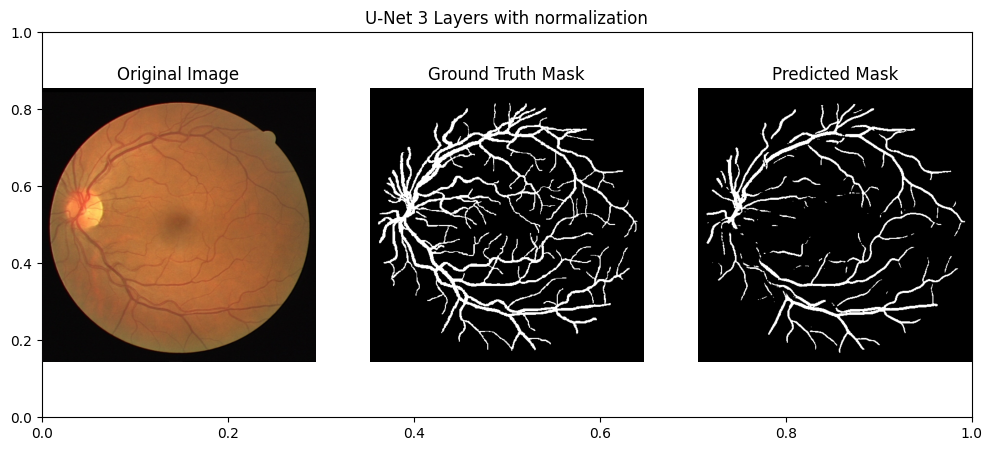

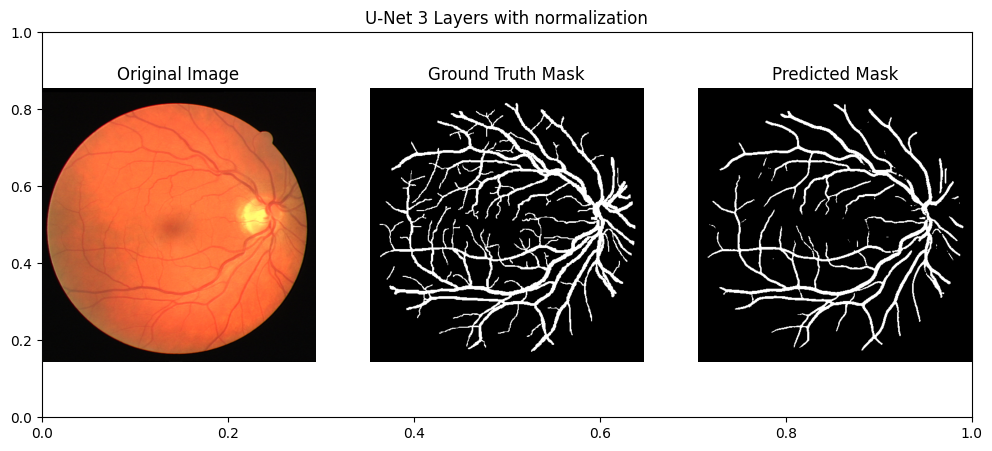

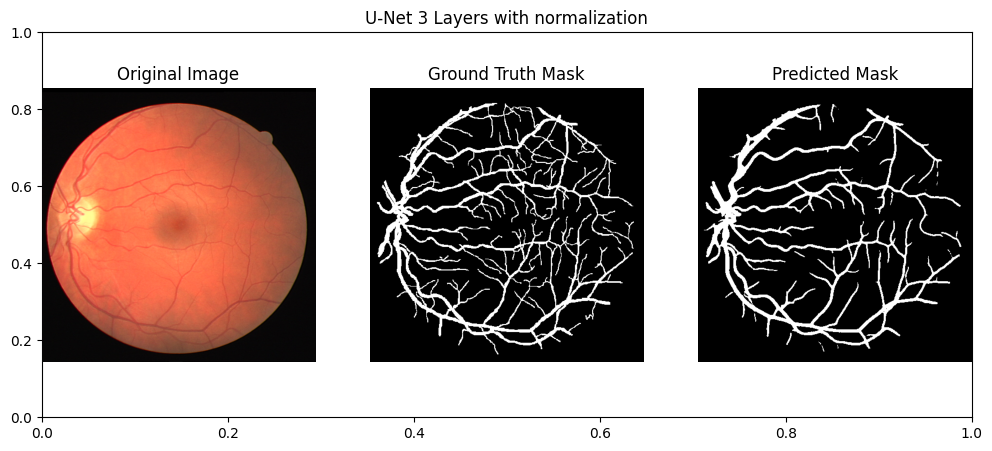

In [ ]:
def display_test_predictions(index):
    # Original image from the test set
    original_image = test_images[index]
    # Ground truth mask from the test set
    ground_truth_mask = test_masks[index]
    # Predicted mask (use `.round()` for binary mask)
    predicted_mask = pred[index].round()

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.title("U-Net 3 Layers with normalization")

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Display predictions for a few samples in the test set
for i in range(3):  # Adjust the range to display more or fewer images
    display_test_predictions(i)

## U-Net 4 layers

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def convolution(input, channels):
    """Convolutional block with two convolutional layers and BatchNormalization."""
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(input)
    x = layers.BatchNormalization()(x)  # Batch normalization after the first Conv2D
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)  # Batch normalization after the second Conv2D
    return x

def encoder(input, channels):
    """Encoder block with convolution and max pooling."""
    x = convolution(input, channels)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder(input, skip_features, channels):
    """Decoder block with upsampling and concatenation with skip connections."""
    x = layers.Conv2DTranspose(channels, (2, 2), strides=2, padding='same')(input)
    x = layers.Concatenate()([x, skip_features])
    x = convolution(x, channels)
    return x

def unet_4_layer_bn(input_shape):
    """Constructs the 4-layer U-Net model with BatchNormalization."""
    inputs = layers.Input(input_shape)

    # Encoder
    l1, p1 = encoder(inputs, 64)
    l2, p2 = encoder(p1, 128)
    l3, p3 = encoder(p2, 256)
    l4, p4 = encoder(p3, 512)

    # Bottleneck
    l = convolution(p4, 1024)

    # Decoder
    u1 = decoder(l, l4, 512)
    u2 = decoder(u1, l3, 256)
    u3 = decoder(u2, l2, 128)
    u4 = decoder(u3, l1, 64)

    # Output layer
    output = layers.Conv2D(1, 1, padding='same', activation="sigmoid")(u4)

    model = models.Model(inputs, output, name="4_LAYER_UNET_BN")
    return model

# Example usage
input_shape = (512, 512, 3)  # Input shape (height, width, channels)
model = unet_4_layer_bn(input_shape)

# Compile the model
model.compile(optimizer= 'adam', loss=combined_bce_dice_loss, metrics=[dice_score, iou_score])

# Model summary
model.summary()


Model: "4_LAYER_UNET_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 512, 512, 64)   │          1,792 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_70    │ (None, 512, 512, 64)   │            256 │ conv2d_75[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 512, 512, 64)   │         36,928 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_71    │ (None, 512, 512, 64)   │            256 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 256, 256, 64)   │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 256, 256, 128)  │            512 │ conv2d_77[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 256, 256, 128)  │        147,584 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 256, 256, 128)  │            512 │ conv2d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 128, 128, 128)  │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 128, 128, 256)  │          1,024 │ conv2d_79[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 128, 128, 256)  │        590,080 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 128, 128, 256)  │          1,024 │ conv2d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# Get current UTC time
utc_now = datetime.now(pytz.utc)

# Convert to your desired time zone (e.g., US Eastern Time)
local_timezone = pytz.timezone('America/New_York')
local_time = utc_now.astimezone(local_timezone)

# Format the time as a string
current_timestamp = local_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the local time
print("Current Time:", local_time.strftime("%Y-%m-%d %H:%M:%S"))

print("U-Net with 4 layers with normalization")
history_unet4_wn = model.fit(train_images, train_masks,
            validation_data=(val_images, val_masks),
           epochs = 5,
           batch_size = 2)

pred = model.predict(test_images)
dice_scores = [dice_score(test_masks[i], pred[i]).numpy() for i in range(len(test_masks))]
iou_scores = [iou_score(test_masks[i], pred[i]).numpy() for i in range(len(test_masks))]

mean_dice_score = np.mean(dice_scores)
mean_iou_score = np.mean(iou_scores)


print(f"Dice Score: {mean_dice_score:.4f}")
print(f"IoU Score: {mean_iou_score:.4f}")

Current Time: 2024-11-07 13:32:14
U-Net with 4 layers with normalization
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 738ms/step - dice_score: 0.7896 - iou_score: 0.6529 - loss: 0.5717 - val_dice_score: 0.7137 - val_iou_score: 0.5565 - val_loss: 0.8264
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 503ms/step - dice_score: 0.7997 - iou_score: 0.6667 - loss: 0.5443 - val_dice_score: 0.7688 - val_iou_score: 0.6256 - val_loss: 0.6317
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - dice_score: 0.8003 - iou_score: 0.6674 - loss: 0.5432 - val_dice_score: 0.7295 - val_iou_score: 0.5754 - val_loss: 0.7568
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 508ms/step - dice_score: 0.8067 - iou_score: 0.6762 - loss: 0.5254 - val_dice_score: 0.7269 - val_iou_score: 0.5719 - val_loss: 0.7488
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 503ms/step - dice_score: 0.8073 - iou_score: 0.6772 - loss: 0.5233 - val_dice_score: 0.7856 - val_iou_score: 0.6475 - val_loss: 0.5960
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Dice Sco

In [ ]:
# Save model weights
from google.colab import files
model.save_weights("unet_4_layer_bn.weights.h5")
files.download('unet_4_layer_bn.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

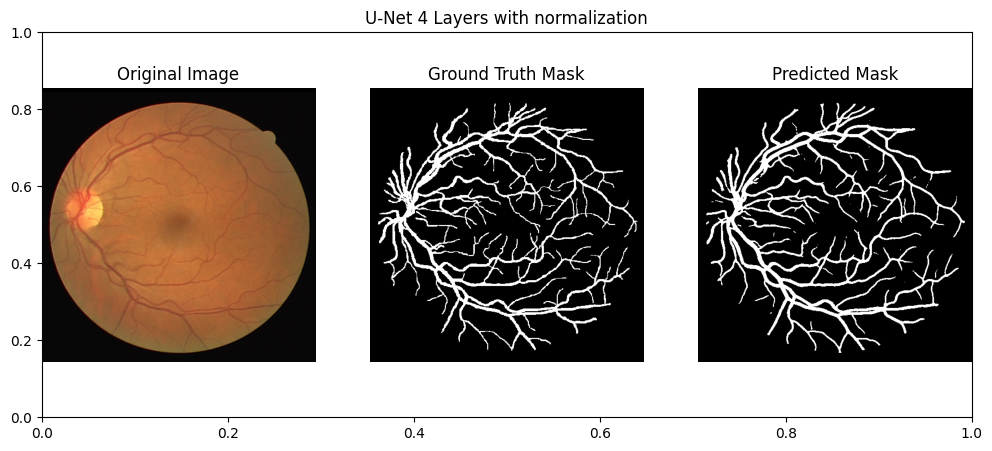

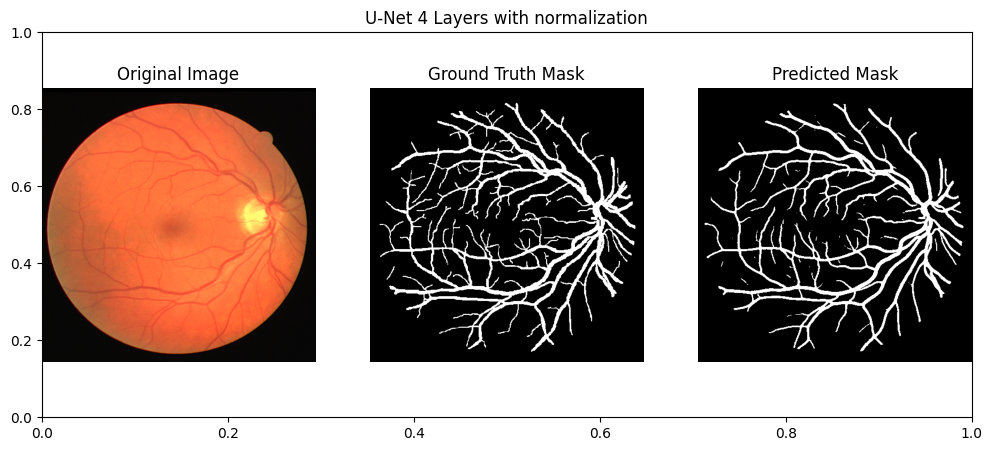

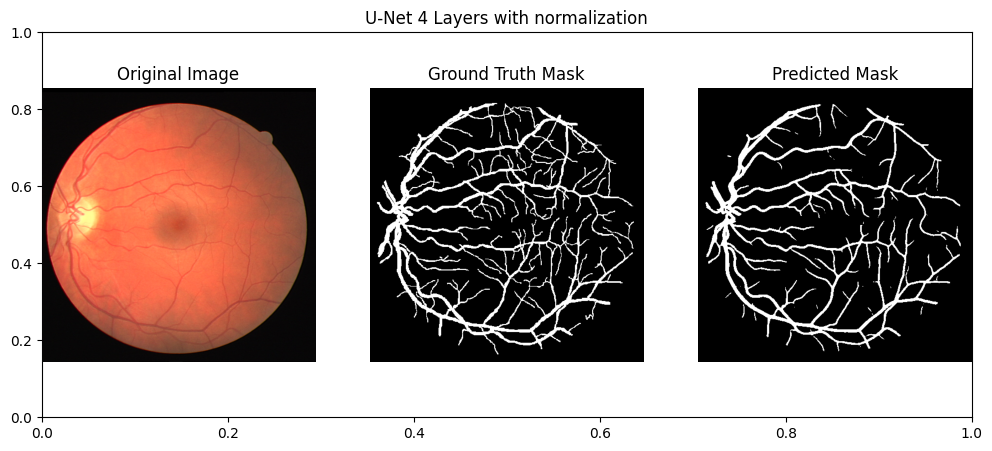

In [ ]:
def display_test_predictions(index):
    # Original image from the test set
    original_image = test_images[index]
    # Ground truth mask from the test set
    ground_truth_mask = test_masks[index]
    # Predicted mask (use `.round()` for binary mask)
    predicted_mask = pred[index].round()

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.title("U-Net 4 Layers with normalization")

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Display predictions for a few samples in the test set
for i in range(3):  # Adjust the range to display more or fewer images
    display_test_predictions(i)